# Imports and params

In [1]:
!pip install -qq transformers

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import math

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# fig_size = (15, 8)
# sns.set(rc={'figure.figsize':fig_size})
# sns.set_context("notebook")
# sns.set_style("whitegrid")
RANDOM_SEED = 13
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!nvidia-smi

Sat Mar 20 17:49:53 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W / 300W |      2MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import data and models

In [6]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [7]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [8]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
DROPOUT = 0.5

class CategoryClassifier(nn.Module):

  def __init__(self, n_classes):
    super(CategoryClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=DROPOUT)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [80]:
data = ['080910', '11', '12', '13', '14', '15', '16', '17', '181920']
dfs = list(range(len(data)))
for i in range(len(data)):
  dfs[i] = pd.read_csv(f'gdrive/MyDrive/Colab/SentimentTutorial/arxiv_{data[i]}.csv')
categories = ['math', 'astro-ph', 'hep-ph', 'math-ph', 'hep-th', 
                 'physics', 'quant-ph', 'cs', 'cond-mat', 'nlin', 'q-bio', 
                 'nucl-th', 'hep-ex', 'gr-qc']

In [11]:
model1, model2 = CategoryClassifier(len(categories)), CategoryClassifier(len(categories))

model1.load_state_dict(torch.load(f'gdrive/MyDrive/Colab/SentimentTutorial/best_model_state_arxiv_080910.bin', map_location=torch.device('cpu')))
model2.load_state_dict(torch.load(f'gdrive/MyDrive/Colab/SentimentTutorial/best_model_state_arxiv_181920.bin', map_location=torch.device('cpu')))  

model1 = model1.to(device)
model2 = model2.to(device)

models = [model1, model2]

# Break initial sets into test sets, "in between" sets are already test-shaped and -sized

We only care about the test sets, but repeat the structure of the splits for both early and late years so that we are sure we are evaluating the models on the same data, and also that we are not evaluating models on data that they were trained on.  **RANDOM_SEED must match FineTuneBert**

In [12]:
TEST_SIZE = .1

strat_targets = dfs[0].cat_int
_, df1_test = train_test_split(dfs[0], test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=strat_targets)
strat_targets2 = df1_test.cat_int
_, dfs[0] = train_test_split(df1_test, test_size=0.5, random_state=RANDOM_SEED, stratify=strat_targets2)

strat_targets = dfs[-1].cat_int
_, df2_test = train_test_split(dfs[-1], test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=strat_targets)
strat_targets2 = df2_test.cat_int
_, dfs[-1] = train_test_split(df2_test, test_size=0.5, random_state=RANDOM_SEED, stratify=strat_targets2)

In [13]:
len(dfs[0]), len(dfs[4]) #should match

(1050, 1050)

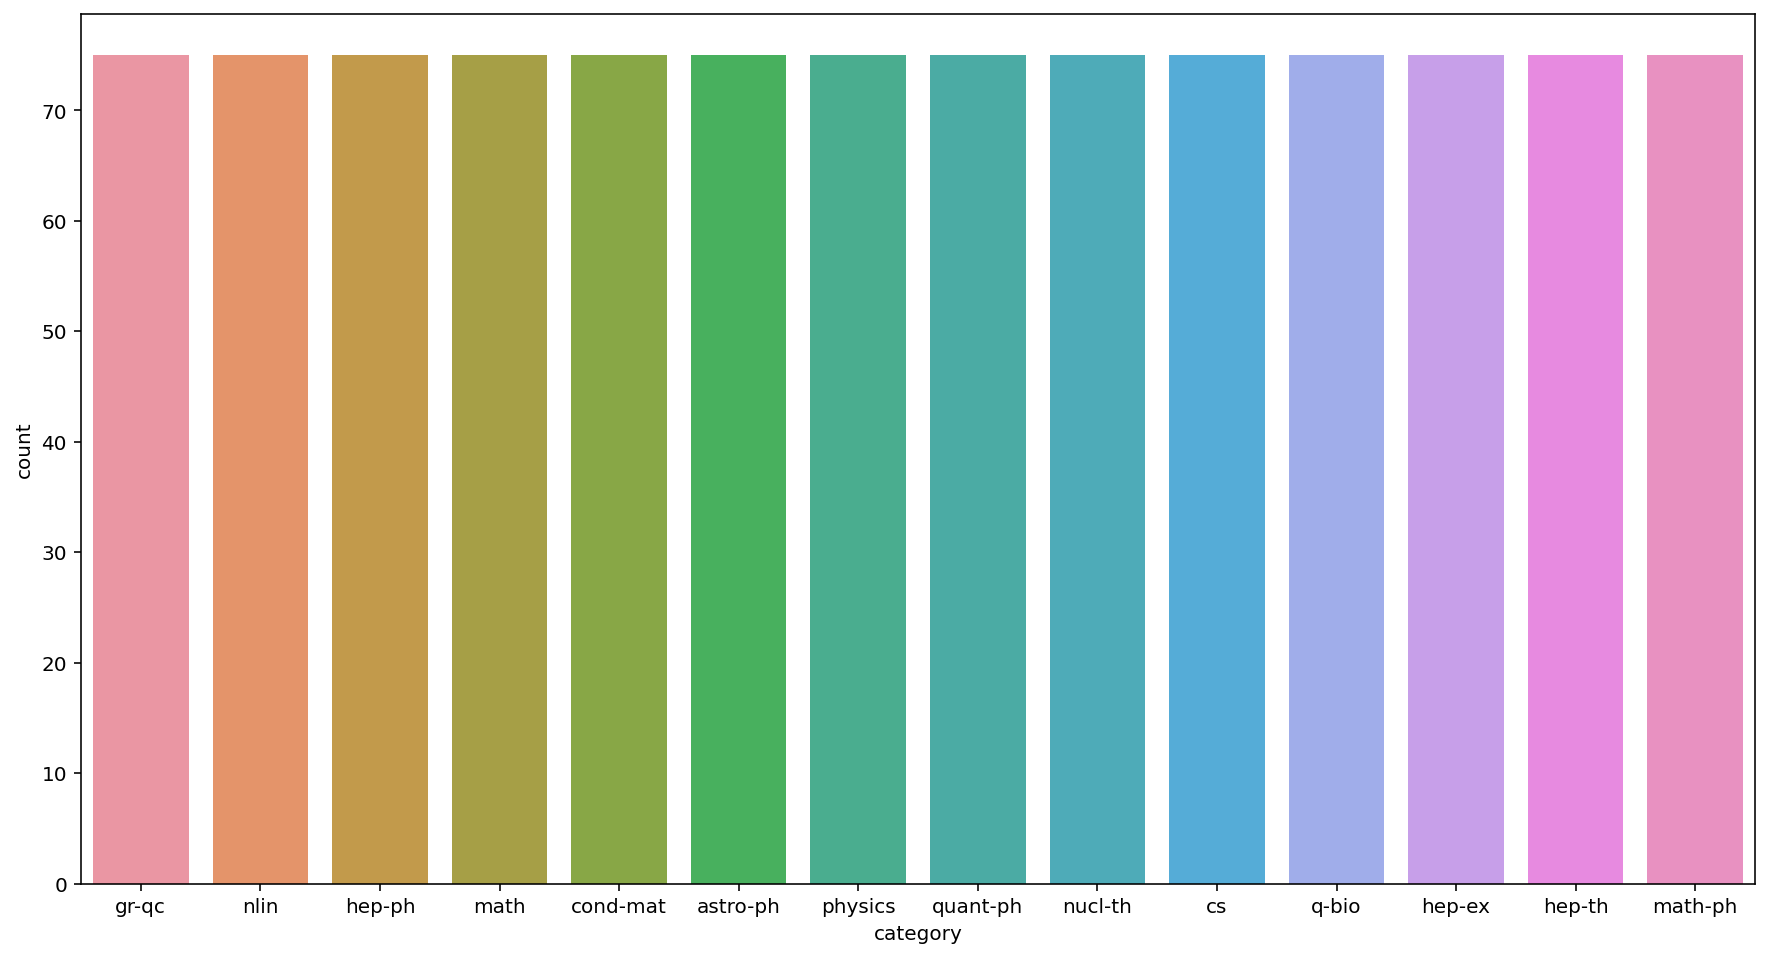

In [14]:
plt.figure(figsize=(15,8))

sns.countplot(x=dfs[0].category)

# Pytorch necessites for evaluating the model

In [15]:
class ArXivAbstractDataset(Dataset):  
  #This class gives the encoding for an abstract selected via "item"?

  def __init__(self, texts, xlists, targets, tokenizer, max_len): 
    self.texts = texts
    self.xlists = xlists
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.texts)
  
  def __getitem__(self, item):
    text = str(self.texts[item])
    croscat = self.xlists[item]
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      truncation=True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'abstract_text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long),
      'cross_list_cats': croscat
    }

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ArXivAbstractDataset(
    texts=df.abstract.to_numpy(),
    xlists=df.cross_lists.to_numpy(),
    targets=df.cat_int.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [17]:
BATCH_SIZE = 10
MAX_LEN = 450

loaders = list(range(len(data)))
for i in range(len(data)):
  loaders[i] = create_data_loader(dfs[i], tokenizer, MAX_LEN, BATCH_SIZE)


# Evaluate all models on all data

In [18]:
loss_fn = nn.CrossEntropyLoss().to(device)
def eval_model(model, data_loader, device, n_examples):
  model = model.eval()

  abstract_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  cross_lists = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      atexts = d["abstract_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      xlists = d['cross_list_cats']

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)
      abstract_texts.extend(atexts)
      cross_lists.extend(xlists)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

      correct_predictions += torch.sum(preds == targets)
      acc = correct_predictions.double() / n_examples


  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()



  return [acc.item(), abstract_texts, predictions, prediction_probs, real_values, cross_lists]

In [19]:
all_info = [[],[]]

for m in range(len(models)):
  for i in range(len(data)):
    results = eval_model(
    models[m],
    loaders[i],
    device,
    len(dfs[i])
    )

    all_info[m].append(results)

# Look at model accuracy as a function of time

In [20]:
acc = [[x[y][0] for y in range(len(data))] for x in all_info]

In [21]:
early_rel_acc = [(acc[0][y] - acc[0][0]) / acc[0][0] for y in range(len(data))] 
late_rel_acc = [(acc[1][y] - acc[1][-1]) / acc[1][-1] for y in range(len(data))] 

In [22]:
def single_multi_cat_acc(y_xlists, y_test, y_pred):
  right_tensor = y_test == y_pred
  right=list(right_tensor.numpy())
  wrong=list(~right_tensor.numpy()) 

  right_y_xlists = [y_xlists[i] for i in range(len(y_xlists)) if right[i]]
  wrong_y_xlists = [y_xlists[i] for i in range(len(y_xlists)) if wrong[i]]

  right_cros_list_len = [0 if len(y)==2 else 1 for y in right_y_xlists]
  wrong_cros_list_len = [0 if len(y)==2 else 1 for y in wrong_y_xlists]

  acc_sing = right_cros_list_len.count(0)/(right_cros_list_len.count(0) + wrong_cros_list_len.count(0))
  acc_multi = right_cros_list_len.count(1)/(right_cros_list_len.count(1) + wrong_cros_list_len.count(1))

  return [acc_sing, acc_multi]

In [23]:
accsing = [[ single_multi_cat_acc(x[y][5], x[y][4], x[y][2])[0]  for y in range(len(data))] for x in all_info]
accmulti = [[single_multi_cat_acc(x[y][5], x[y][4], x[y][2])[1]  for y in range(len(data))] for x in all_info]

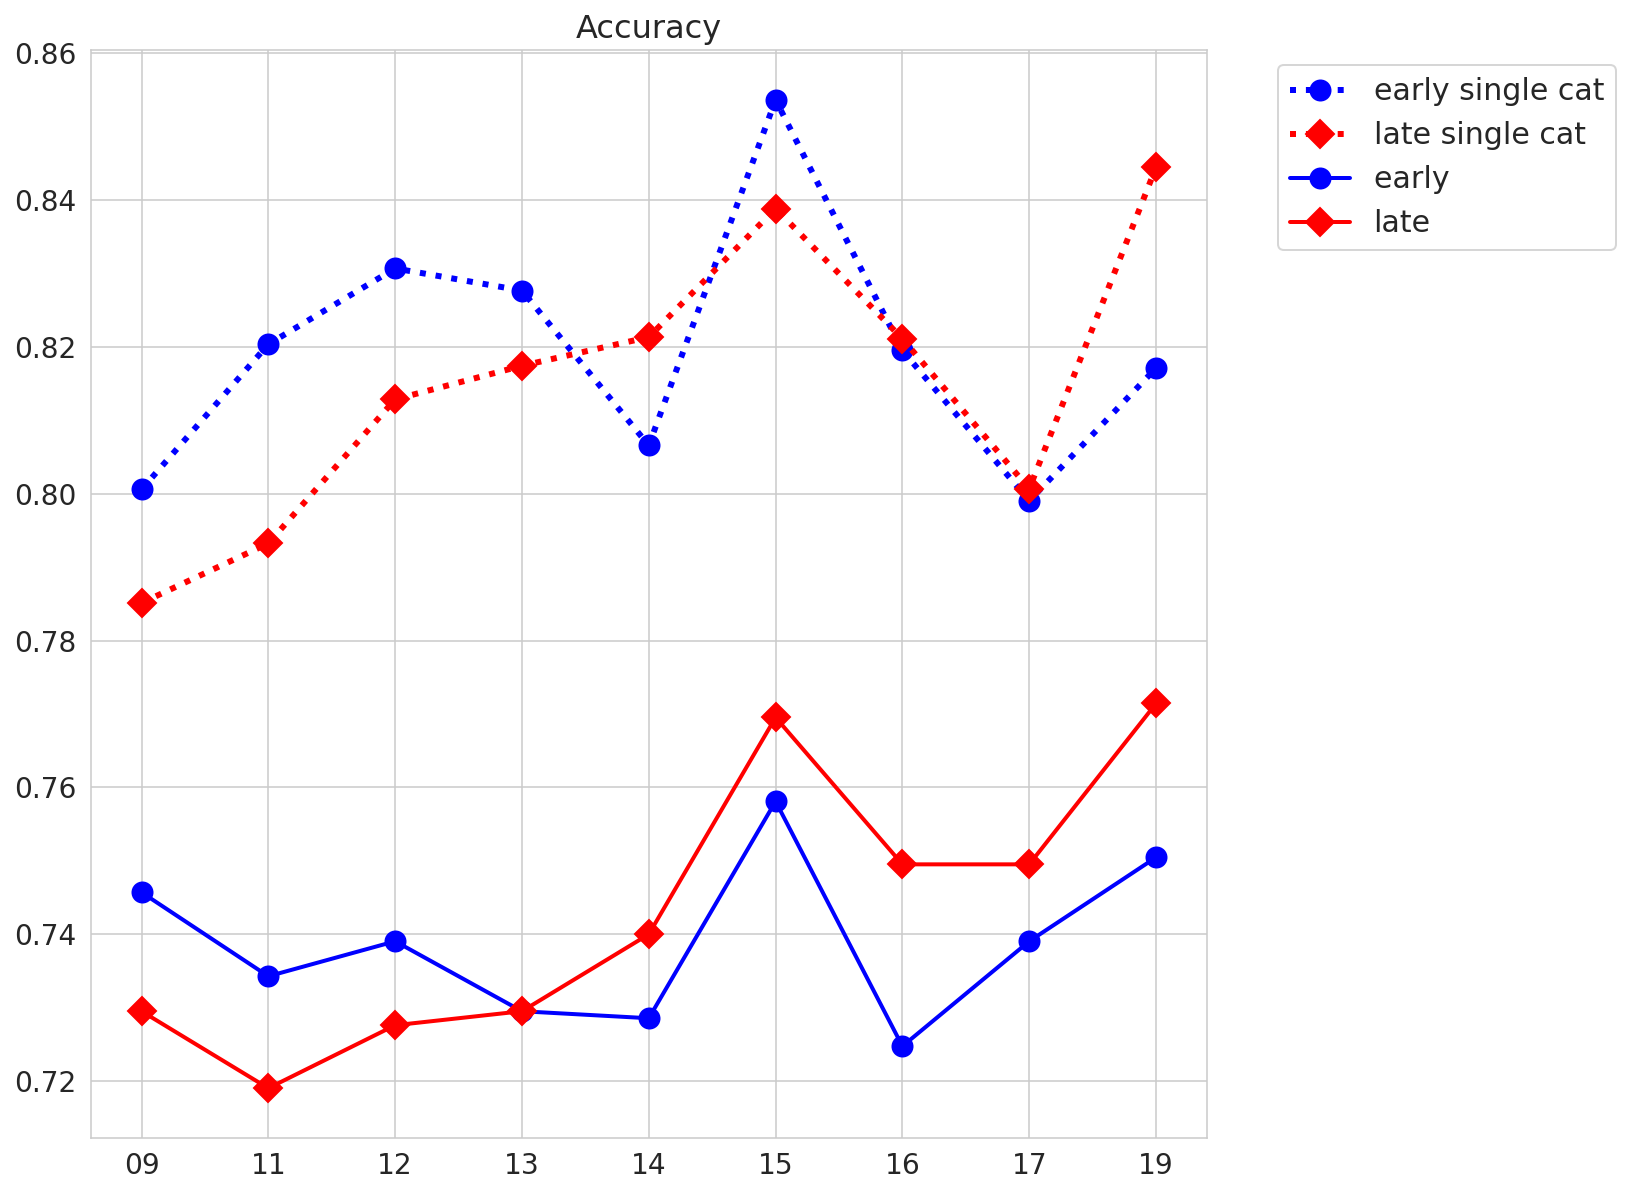

In [78]:
year_space = ([0] + [len(data)*(int(yr)-9)/10 for yr in data[1:-1]] + [(len(data))*1])
year_labels = ['09', '11', '12', '13', '14', '15', '16', '17', '19']
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
plt.plot(accsing[0], ':b', marker='o', label='early single cat', linewidth=3, markersize=10)
plt.plot(accsing[1], ':r', marker='D', markersize=10, label='late single cat', linewidth=3)

plt.plot(acc[0], '-b', marker='o', label='early ', linewidth=2, markersize=10)
plt.plot(acc[1], '-r', marker='D', markersize=10, label='late', linewidth=2)

plt.xticks(ticks=range(len(data)), labels=year_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Accuracy', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size':15})
plt.show()

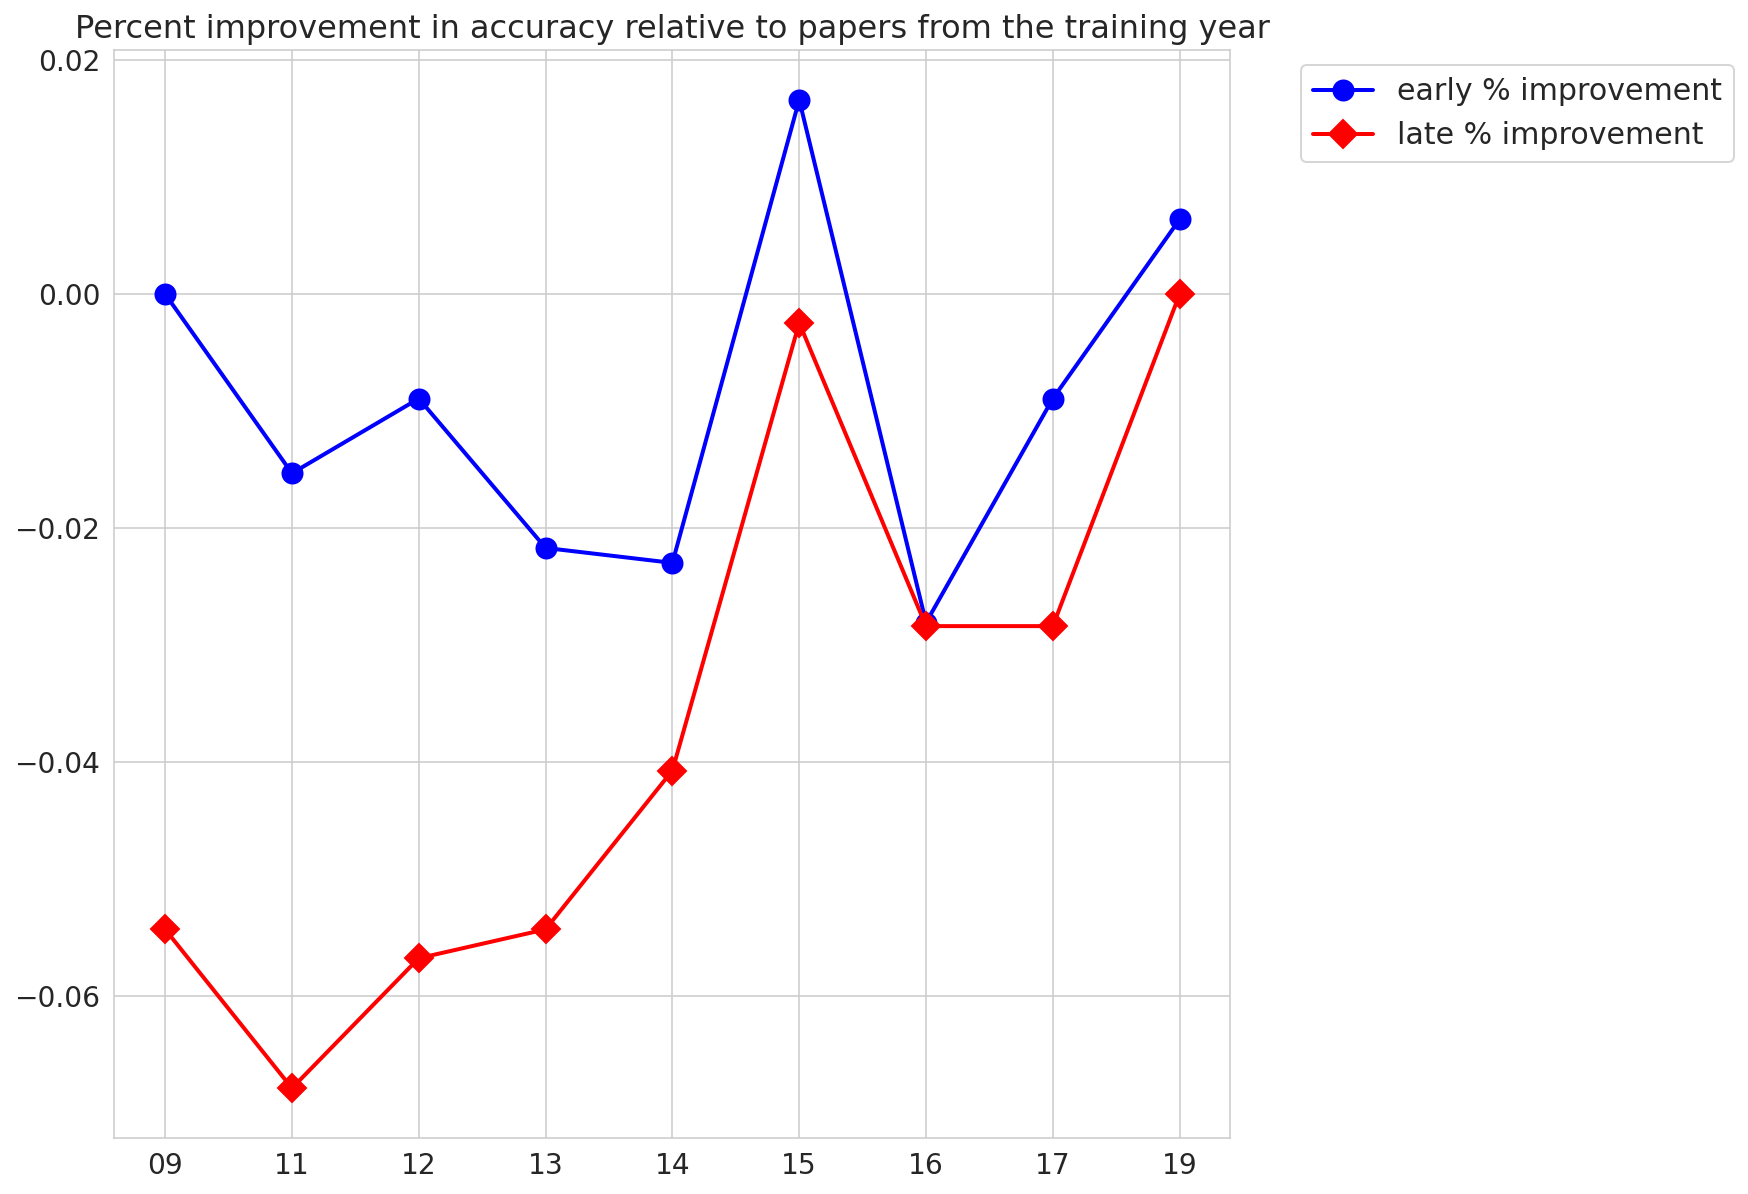

In [79]:
year_space = ([0] + [len(data)*(int(yr)-9)/10 for yr in data[1:-1]] + [(len(data))*1])
sns.axes_style('whitegrid')
plt.figure(figsize=(10,10))
plt.plot(early_rel_acc, '-b', marker='o', label='early % improvement', linewidth=2, markersize=10)
plt.plot(late_rel_acc, '-r', marker='D', markersize=10, label='late % improvement', linewidth=2)

plt.xticks(ticks=range(len(data)), labels=year_labels, fontsize=14)
plt.yticks( fontsize=14)
plt.title('Percent improvement in accuracy relative to papers from the training year', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size':15})
plt.show()

# Look at single-category submission accuracy per subfield

In [69]:
datasc = ['080910', '11', '12', '13', '14', '15', '16', '17', '181920']
dfs_sc = list(range(len(data)))
for i in range(len(data)):
  dfs_sc[i] = pd.read_csv(f'gdrive/MyDrive/Colab/SentimentTutorial/arxiv_{data[i]}_sincat.csv')

In [70]:
dfs_sc[0].shape

(14164, 6)

In [71]:
loaders_sc = list(range(len(data)))
for i in range(len(data)):
  loaders_sc[i] = create_data_loader(dfs_sc[i], tokenizer, MAX_LEN, BATCH_SIZE)


In [72]:
def cat_acc(y_test, y_pred):
  yt = y_test.numpy()
  yp = y_pred.numpy()
  right = yt == yp

  category_acc = []
  for i in range(len(categories)):
    booli = [i == y for y in yt]
    if sum(booli) == 0:
      category_acc.append(1)
      continue 
    cat_right = sum([1 if booli[j] and right[j] else 0 for j in range(len(booli))]) 
    acc = cat_right / sum(booli)
    category_acc.append(acc)

  return category_acc

In [73]:
all_info_sc = [[],[]]

for m in range(len(models)):
  for i in range(len(data)):
    results = eval_model(
    models[m],
    loaders_sc[i],
    device,
    len(dfs_sc[i])
    )

    all_info_sc[m].append(results)

In [75]:
accuracy_per_cat = [[ cat_acc(x[y][4], x[y][2])  for y in range(len(data))] for x in all_info_sc]

In [76]:
cat_accuracy_permodel = [[[accuracy_per_cat[m][y][j] for y in range(len(data))] for j in range(len(categories))] for m in range(2)]

In [82]:
categories

['math',
 'astro-ph',
 'hep-ph',
 'math-ph',
 'hep-th',
 'physics',
 'quant-ph',
 'cs',
 'cond-mat',
 'nlin',
 'q-bio',
 'nucl-th',
 'hep-ex',
 'gr-qc']

<Figure size 432x288 with 0 Axes>

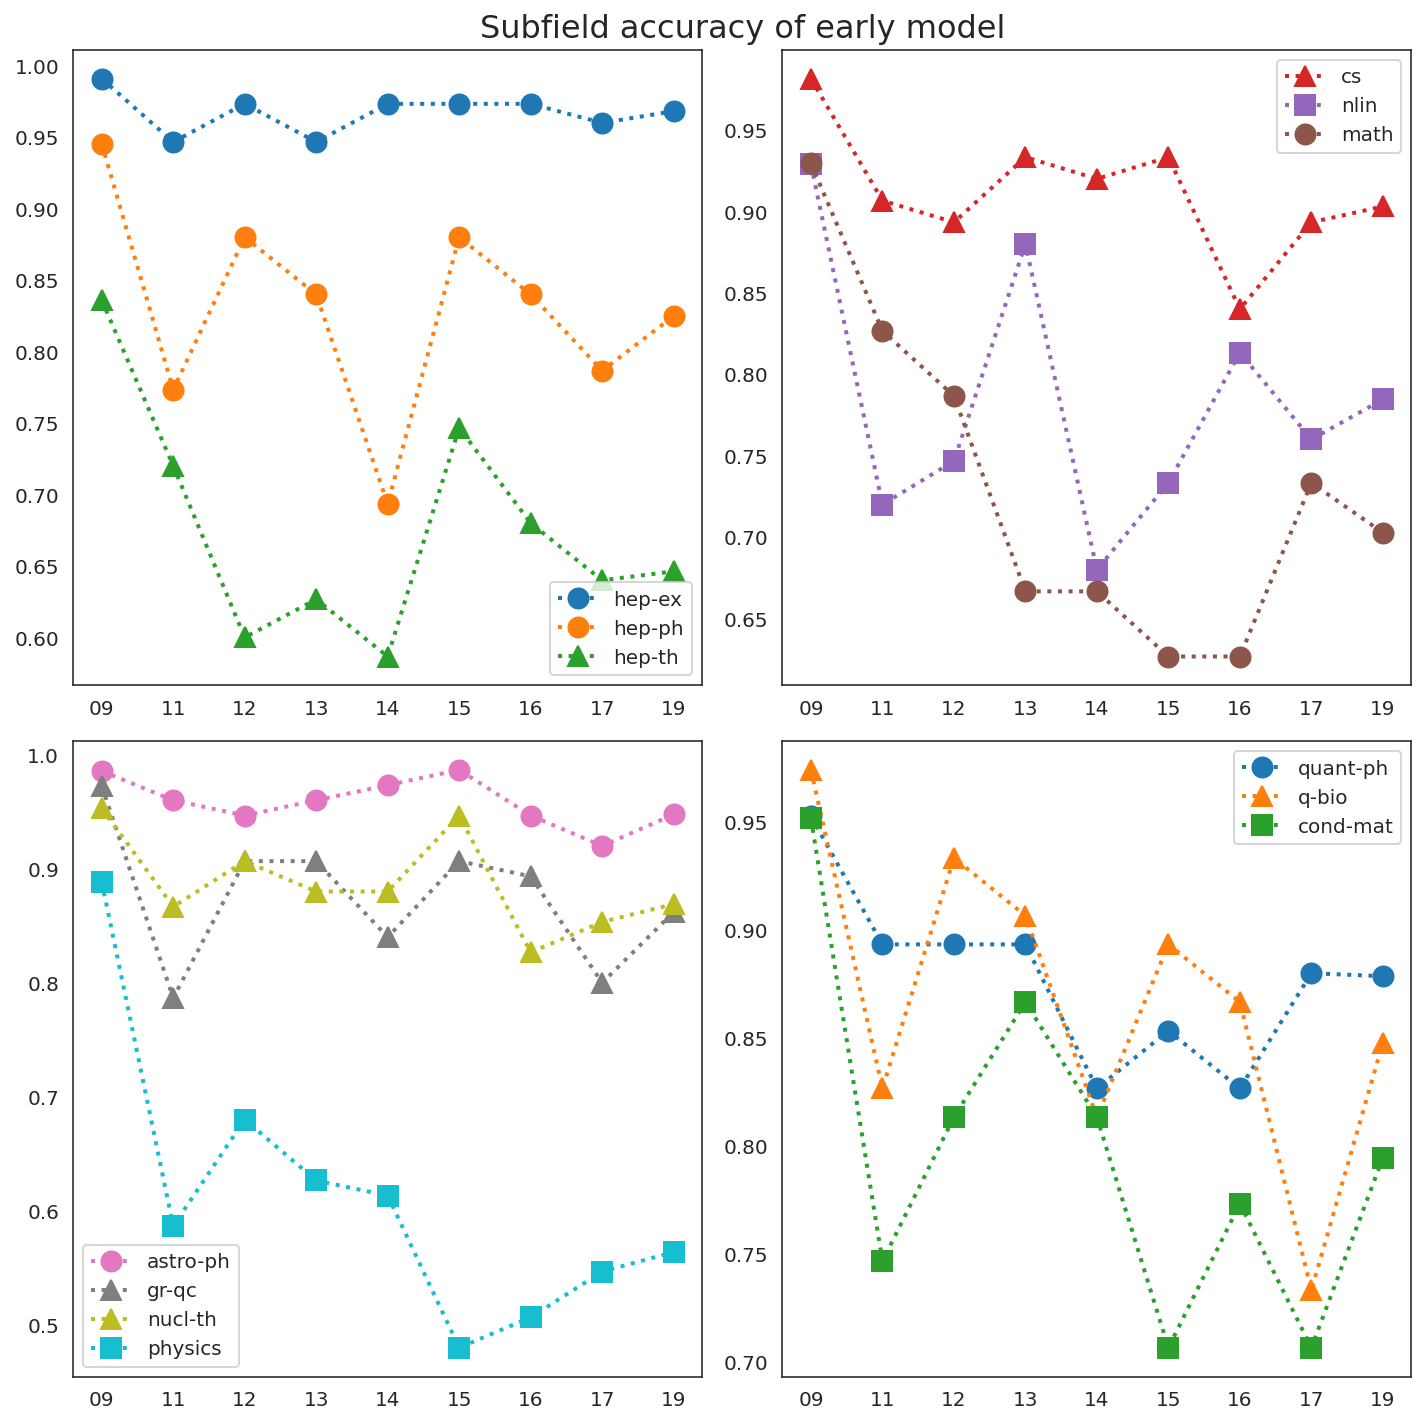

In [92]:

with sns.axes_style('white'):
  sns.despine()
  palette = iter(sns.color_palette('tab10', 14))
  f = plt.figure(figsize=(10, 10))

  plt.tick_params(bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
  for pos in ['right', 'top', 'bottom', 'left']: 
      plt.gca().spines[pos].set_visible(False) 

  plt.title('Subfield accuracy of early model', fontsize=16)
  count=0
  gs = f.add_gridspec(2, 2)

  ax = f.add_subplot(gs[0, 0])
  plt.plot(cat_accuracy_permodel[0][12], ':', marker='o', markersize=10, label=categories[12], linewidth=2, color=next(palette))
  plt.plot(cat_accuracy_permodel[0][2], ':', marker='o', markersize=10, label=categories[2], linewidth=2, color=next(palette))
  plt.plot(cat_accuracy_permodel[0][4], ':', marker='^', markersize=10, label=categories[4], linewidth=2, color=next(palette))
  plt.legend()
  plt.xticks(ticks=range(len(data)), labels=year_labels)

  ax = f.add_subplot(gs[0, 1])
  plt.plot(cat_accuracy_permodel[0][7], ':', marker='^', markersize=10, label=categories[7], linewidth=2, color=next(palette))
  plt.plot(cat_accuracy_permodel[0][9], ':', marker='s', markersize=10, label=categories[9], linewidth=2, color=next(palette))
  plt.plot(cat_accuracy_permodel[0][0], ':', marker='o', markersize=10, label=categories[0], linewidth=2, color=next(palette))

  plt.legend()
  plt.xticks(ticks=range(len(data)), labels=year_labels)

  ax = f.add_subplot(gs[1, 0])
  plt.plot(cat_accuracy_permodel[0][1], ':', marker='o', markersize=10, label=categories[1], linewidth=2, color=next(palette))
  plt.plot(cat_accuracy_permodel[0][13], ':', marker='^', markersize=10, label=categories[13], linewidth=2, color=next(palette))
  plt.plot(cat_accuracy_permodel[0][11], ':', marker='^', markersize=10, label=categories[11], linewidth=2, color=next(palette))
  plt.plot(cat_accuracy_permodel[0][5], ':', marker='s', markersize=10, label=categories[5], linewidth=2, color=next(palette))
  plt.legend()
  plt.xticks(ticks=range(len(data)), labels=year_labels)

  ax = f.add_subplot(gs[1, 1])
  plt.plot(cat_accuracy_permodel[0][6], ':', marker='o', markersize=10, label=categories[6], linewidth=2, color=next(palette))
  plt.plot(cat_accuracy_permodel[0][10], ':', marker='^', markersize=10, label=categories[10], linewidth=2, color=next(palette))
  plt.plot(cat_accuracy_permodel[0][8], ':', marker='s', markersize=10, label=categories[8], linewidth=2, color=next(palette))

  plt.legend()
  plt.xticks(ticks=range(len(data)), labels=year_labels)

  plt.legend()
  plt.xticks(ticks=range(len(data)), labels=year_labels)


  f.tight_layout()
  plt.show